/home/oppenheimer/anaconda3/envs/wip/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/oppenheimer/anaconda3/envs/wip/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

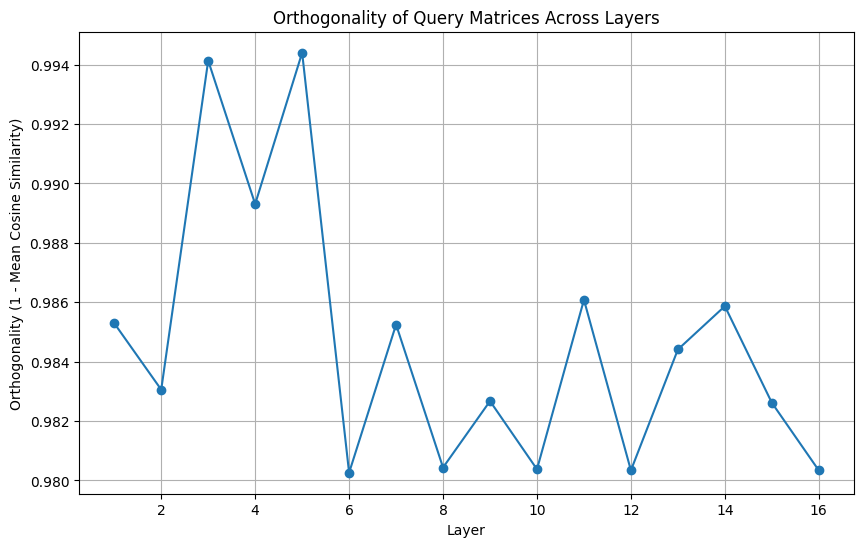

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Function to extract grouped query weights for all layers
def extract_grouped_query_weights(model, layer_name_substring="self_attn.q_proj"):
    query_weights_per_layer = []
    for name, param in model.named_parameters():
        if layer_name_substring in name and "weight" in name:
            query_weights_per_layer.append((name, param.detach().cpu().numpy()))
    return query_weights_per_layer

# Function to compute orthogonality metric
def compute_orthogonality(query_weights, metric="cosine"):
    num_groups = query_weights.shape[0]  # Number of query matrices
    pairwise_matrix = np.zeros((num_groups, num_groups))

    # Compute pairwise cosine similarity or correlation
    for i in range(num_groups):
        for j in range(num_groups):
            matrix_i = query_weights[i].reshape(-1)
            matrix_j = query_weights[j].reshape(-1)
            if metric == "cosine":
                norm_i = np.linalg.norm(matrix_i)
                norm_j = np.linalg.norm(matrix_j)
                pairwise_matrix[i, j] = np.dot(matrix_i, matrix_j) / (norm_i * norm_j)
            elif metric == "correlation":
                pairwise_matrix[i, j] = np.corrcoef(matrix_i, matrix_j)[0, 1]

    # Compute average off-diagonal similarity (orthogonality metric)
    off_diagonal = pairwise_matrix[np.triu_indices(num_groups, k=1)]  # Exclude diagonal
    mean_similarity = np.mean(off_diagonal)
    return 1 - mean_similarity  # Closer to 1 indicates high orthogonality

# Compute orthogonality for all layers
query_weights_per_layer = extract_grouped_query_weights(model)
orthogonality_scores = []

for name, weights in query_weights_per_layer:
    query_groups = np.split(weights, 16, axis=0)  # Assuming 16 groups split along 0th axis
    orthogonality = compute_orthogonality(np.array(query_groups), metric="cosine")
    orthogonality_scores.append(orthogonality)

# Plot orthogonality scores across layers
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(orthogonality_scores) + 1), orthogonality_scores, marker="o", linestyle="-")
plt.title("Orthogonality of Query Matrices Across Layers")
plt.xlabel("Layer")
plt.ylabel("Orthogonality (1 - Mean Cosine Similarity)")
plt.grid(True)
plt.show()


In [2]:
orthogonality_scores

[0.9852923909604822,
 0.9830558281477352,
 0.9941365492834469,
 0.989306041765667,
 0.9944022819454706,
 0.9802585288117976,
 0.9852480142707161,
 0.9804339317615813,
 0.9826707983015998,
 0.9803750307593266,
 0.9860806916786108,
 0.9803374756277966,
 0.984408174906639,
 0.9858679346833621,
 0.9826155996678911,
 0.9803362689118936]